# Load trained models
This file shows this project used saved models to evaluate model performance.

In [84]:
# find anomaly location in testset, for plot
def find_anomaly_windows(y_test, min_length=10):
    anomaly_windows = []
    in_anomaly = False
    start_idx = 0

    for i in range(len(y_test)):
        if y_test[i] == 1 and not in_anomaly:
            # anomaly start
            in_anomaly = True
            start_idx = i
        elif y_test[i] == 0 and in_anomaly:
            # anomaly end
            in_anomaly = False
            if i - start_idx >= min_length:
                anomaly_windows.append((start_idx, i-1))

    # last window
    if in_anomaly and len(y_test) - start_idx >= min_length:
        anomaly_windows.append((start_idx, len(y_test)-1))

    return anomaly_windows

def plot_reconstruction_comparison(X_test, X_recon, y_test, anomaly_windows,
                                  feature_names, config, model_name=None,  anomaly_scores=None, threshold=None):
    if len(anomaly_windows) == 0:
        print("No anomaly windows found to visualize!")
        return

    if config.VIS_WINDOW_SEQ >= len(anomaly_windows):
        print(f"Warning: VIS_WINDOW_SEQ={config.VIS_WINDOW_SEQ} exceeds number of windows. Using first window.")
        target_window = anomaly_windows[0]
    else:
        target_window = anomaly_windows[config.VIS_WINDOW_SEQ]

    # plot range
    start_idx = max(0, target_window[0] - config.VIS_WINDOW_RANGE)
    end_idx = min(len(X_test), target_window[1] + config.VIS_WINDOW_RANGE)

    # use feature name to plot
    vis_features = config.VIS_FEATURES
    feature_indices = []
    selected_feature_names = []

    for feat in vis_features:
        if isinstance(feat, str):
            if feat in feature_names:
                idx = feature_names.index(feat)
                feature_indices.append(idx)
                selected_feature_names.append(feat)
            else:
                print(f"Warning: Feature '{feat}' not found in feature_names")
        elif isinstance(feat, int):
            # use feature idx to plot
            if feat < len(feature_names):
                feature_indices.append(feat)
                selected_feature_names.append(feature_names[feat])
            else:
                print(f"Warning: Feature index {feat} exceeds data dimensions")

    # use 4 features
    # if not feature_indices:
    #     print(f"Using first {min(4, X_test.shape[1])} features as fallback")
    #     feature_indices = list(range(min(4, X_test.shape[1])))
    #     selected_feature_names = [feature_names[i] if i < len(feature_names) else f"Feature_{i}"
    #                              for i in feature_indices]

    # x axis
    time_axis = np.arange(0, end_idx - start_idx)

    for feat_idx, feat_name in zip(feature_indices, selected_feature_names):
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))

        # original data and reconstruction data
        ax.plot(time_axis, X_test[start_idx:end_idx, feat_idx],
                'k-', label='Original', linewidth=1.2, alpha=0.8)
        ax.plot(time_axis, X_recon[start_idx:end_idx, feat_idx],
                'b-', label='Reconstruction', linewidth=1.2, alpha=0.8)

        if anomaly_scores is not None and threshold is not None:
            window_scores = anomaly_scores[start_idx:end_idx]
            detected_anomalies = window_scores > threshold

            anomaly_indices = np.where(detected_anomalies)[0]
            if len(anomaly_indices) > 0:
                ax.scatter(anomaly_indices, X_test[start_idx:end_idx, feat_idx][anomaly_indices],
                          c='red', s=20, alpha=0.6, marker='x', label='Detected Anomaly', zorder=5)

        # highlight anomaly range
        anomaly_plotted = False
        for anom_start, anom_end in anomaly_windows:
            if anom_end >= start_idx and anom_start <= end_idx:
                label = 'Anomaly' if not anomaly_plotted else ""
                ax.axvspan(max(anom_start - start_idx, 0),
                          min(anom_end - start_idx, end_idx - start_idx),
                          alpha=0.3, color='red', label=label)
                anomaly_plotted = True

        ax.set_xlabel('Time (seconds)', fontsize=11)
        ax.set_ylabel('Value', fontsize=11)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)

        y_min = min(X_test[start_idx:end_idx, feat_idx].min(),
                   X_recon[start_idx:end_idx, feat_idx].min())
        y_max = max(X_test[start_idx:end_idx, feat_idx].max(),
                   X_recon[start_idx:end_idx, feat_idx].max())
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

        if model_name == 'Baseline_LSTM':
            model_name = 'LSTM-AE'
        elif model_name == 'Attention_LSTM':
            model_name = 'Attention LSTM-AE'
        elif model_name == 'LSTM_VAE':
            model_name = 'LSTM-VAE'
        elif model_name == 'Attn_LSTM_VAE':
            model_name = 'Attention LSTM-VAE'

        title = f'{model_name}        {feat_name}'

        ax.set_title(title, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

# get full reconstruction results
def get_full_reconstruction(model, X_test, config):
    test_dataset = TimeSeriesWindowDataset(X_test, config.SEQ_LEN, stride=1)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    model.eval()
    reconstructions = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(config.DEVICE)
            out = model(batch)
            recon = out[0] if isinstance(out, tuple) else out
            reconstructions.append(recon.cpu().numpy())

    # concat all reconstrution windows
    all_recons = np.concatenate(reconstructions, axis=0)  # (N_windows, seq_len, F)

    X_recon = np.zeros_like(X_test)
    counts = np.zeros(len(X_test))

    for i in range(len(all_recons)):
        start_idx = i  # stride=1
        end_idx = start_idx + config.SEQ_LEN
        if end_idx <= len(X_test):
            X_recon[start_idx:end_idx] += all_recons[i]
            counts[start_idx:end_idx] += 1

    counts[counts == 0] = 1
    X_recon = X_recon / counts.reshape(-1, 1)

    return X_recon

Using device: cuda
Running Dataset:SWAT

Loading data...
Original training data shape: (495000, 53)
After removing first 5 hours: (477000, 53)
Removing 14 zero-variance features:
P102, P201, P202, P204, P206, P401, P402, P403, P404, UV401, P501, P502, P601, P603
Number of features: 37
Feature names: ['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']...
 Test-only. Load from: /content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_res01

Found 35 anomaly windows in test set:

--- Visualizing SWAT_Baseline_LSTM ---


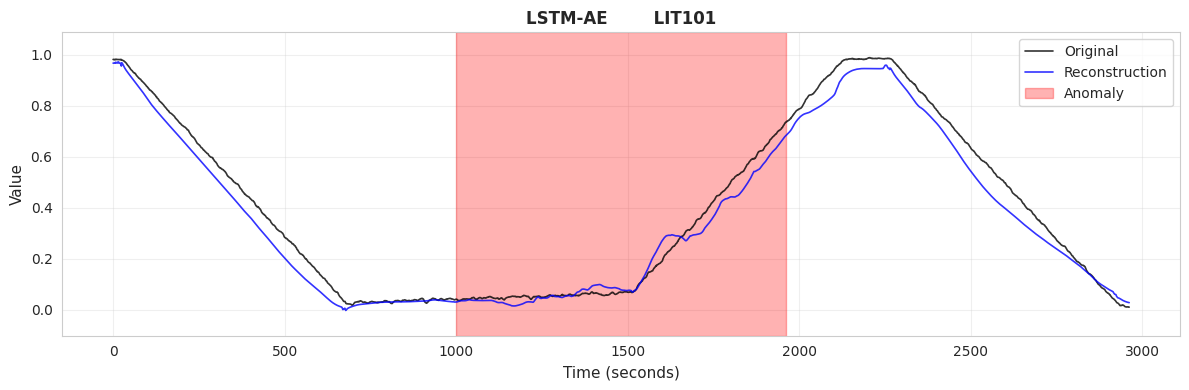


--- Visualizing SWAT_Attention_LSTM ---


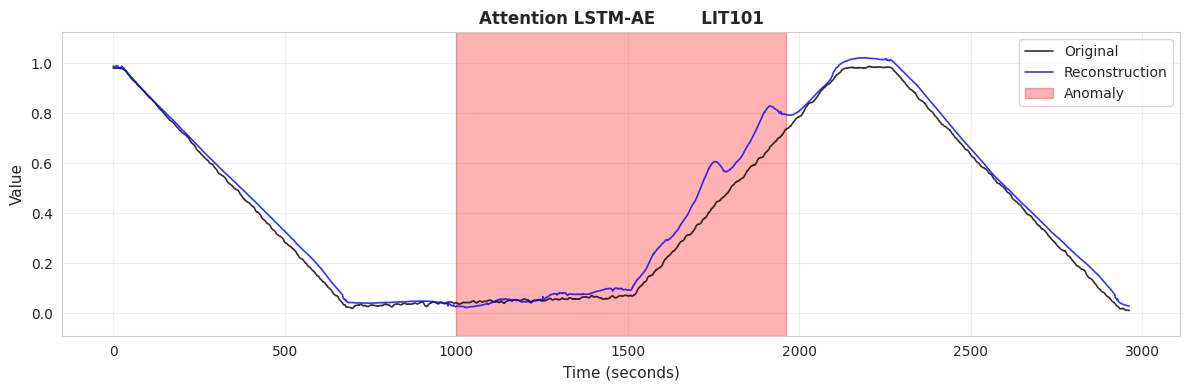


--- Visualizing SWAT_LSTM_VAE ---


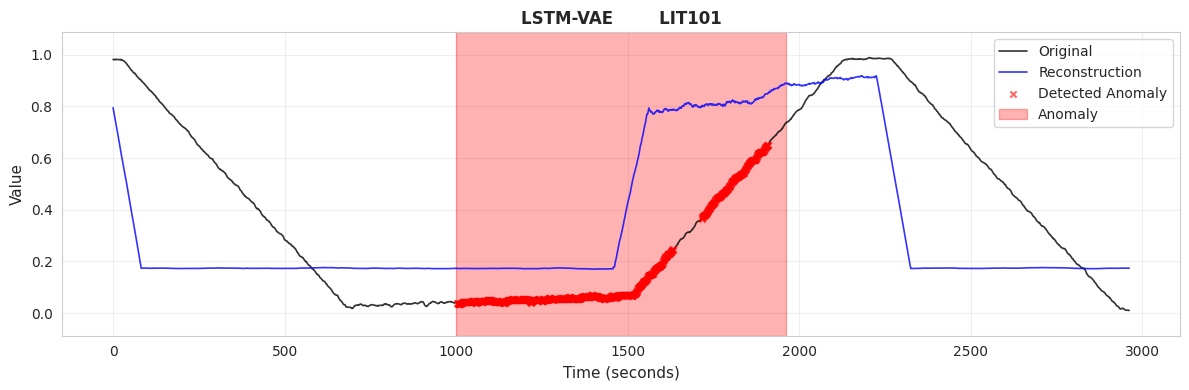


--- Visualizing SWAT_Attn_LSTM_VAE ---


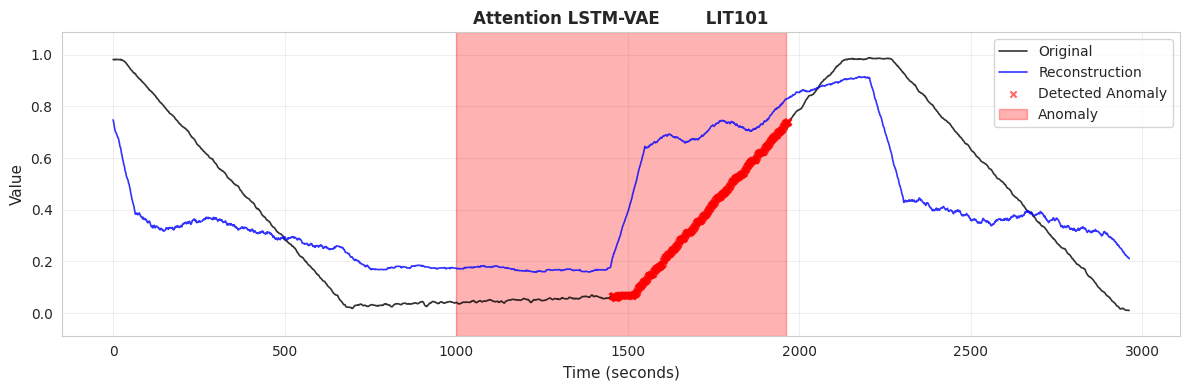

In [85]:
# ======================== Main Execution ========================
class Config:
    # 'SWAT' / 'SMAP' / 'MSL'
    DATASET   = 'SWAT'
    # DATASET   = 'SMAP'

    # MODE = 'train'     # 'train'：train models 'test'：only test, no save
    # LOAD_RUN = None    # in train mode, set LOAD_RUN = None

    MODE = 'test'
    LOAD_RUN = "/content/drive/MyDrive/Colab Notebooks/P_Models/SWAT_res01"


    # VIS_FEATURES = ['FIT301', 'LIT101', 'MV101', 'P101']  # plot features
    VIS_FEATURES = ['LIT101']  # plot features
    VIS_WINDOW_RANGE = 1000
    VIS_WINDOW_SEQ = 6

    SAVE_CKPT = True # if save model
    SAVE_ARTIFACTS = True # if save result

    VAE_BETA = 1.0    # KL （Beta-VAE）
    VAE_DETERMINISTIC_EVAL = False  # when evaluate, use mu downsampling


    DATA_DIR  = Path("/content/drive/MyDrive/Colab Notebooks/P_Dataset")
    SEQ_LEN   = 100
    STRIDE    = 1
    BATCH_SIZE= 64
    HIDDEN_DIM= 64
    NUM_LAYERS= 2
    DROPOUT   = 0.2
    LEARNING_RATE = 1e-3
    NUM_EPOCHS    = 30
    PATIENCE      = 15
    GRADIENT_CLIP = 1.0
    REMOVE_HOURS  = 5   # only SWAT use
    SEED          = 0
    VAL_SPLIT     = 0.2
    THR_STEP = 1000
    ANOMALY_METRICS = ['mse', 'iqr', 'maha']

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adjust_for_dataset(cfg: Config):
    if cfg.DATASET.upper() in ('SMAP', 'MSL'):
        config.SAVE_CKPT = False
        config.SAVE_ARTIFACTS = False
        cfg.SEQ_LEN = 50    # MSL,SMAP, set SEQ_LEN = 50
        cfg.REMOVE_HOURS = 0


config = Config()
print(f"Using device: {config.DEVICE}")

# ======================== Main Execution ========================
def main():
    adjust_for_dataset(config)
    print(f'Running Dataset:{config.DATASET}\n')

    datasets = load_dataset(config)
    all_model_results, all_model_stats = {}, {}
    global_scores, global_labels = [], []

    # Create save dir
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if config.MODE == 'train':
        if config.SAVE_ARTIFACTS:   # only save SWAT
            run_dir = Path("/content/drive/MyDrive/Colab Notebooks/P_Models") / \
                    f"{config.DATASET}_{timestamp}_seed{config.SEED}"
            run_dir.mkdir(parents=True, exist_ok=True)
            # print(f"Save to: {run_dir}")
        else:
            run_dir = None

    else:  # 'test' mode
        if config.LOAD_RUN is None:
            raise ValueError("config.MODE='test', set config.LOAD_RUN as run_dir ")
        run_dir = Path(config.LOAD_RUN)
        if not run_dir.exists():
            raise FileNotFoundError(f"LOAD_RUN does not exist: {run_dir}")
        print(f" Test-only. Load from: {run_dir}")

    # test-only
    if config.MODE == 'test':
        for ds_name, (X_tr, X_te, y_te, scaler, feat_cols) in datasets.items():
            input_dim = X_tr.shape[1]
            models = {
                'Baseline_LSTM': LSTMAutoencoder(input_dim, config.HIDDEN_DIM, config.NUM_LAYERS,
                                                 config.SEQ_LEN, dropout=config.DROPOUT).to(config.DEVICE),
                'Attention_LSTM': AttentionLSTMAutoencoder(input_dim, config.HIDDEN_DIM, config.NUM_LAYERS,
                                                            config.SEQ_LEN, dropout=config.DROPOUT).to(config.DEVICE),
                'LSTM_VAE': LSTMVAE(input_dim, config.HIDDEN_DIM, config.NUM_LAYERS, config.SEQ_LEN,
                                    dropout=config.DROPOUT, use_init_state=True,
                                    deterministic_eval=config.VAE_DETERMINISTIC_EVAL).to(config.DEVICE),
                'Attn_LSTM_VAE': AttentionLSTMVAE(input_dim, config.HIDDEN_DIM, config.NUM_LAYERS, config.SEQ_LEN,
                                                  dropout=config.DROPOUT, use_init_state=True,
                                                  deterministic_eval=config.VAE_DETERMINISTIC_EVAL).to(config.DEVICE),
            }
            # for mdl_name, mdl in models.items():
            #     tag = f"{ds_name}_{mdl_name}"
            #     ckpt = run_dir / f"{tag}.pth"
            #     if not ckpt.exists():
            #         print(f"dont find ckpt: {ckpt}")
            #         continue
            #     mdl.load_state_dict(torch.load(ckpt, map_location=config.DEVICE))
            #     mdl.to(config.DEVICE)
            #     print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
            #     print(f"\n use saved skpt：{tag}")
            #     print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
            #     evaluate_checkpoint(tag, mdl, X_tr, X_te, y_te, config)


            # 1. test anomaly windows
            anomaly_windows = find_anomaly_windows(y_te, min_length=10)
            print(f"\nFound {len(anomaly_windows)} anomaly windows in test set:")
            for i, (start, end) in enumerate(anomaly_windows[:]):  # 只打印前10个
                duration = end - start + 1
                # print(f"  Window {i+1}: [{start:6d}, {end:6d}] (duration: {duration:4d} samples)")


            # 2. visualization
            for mdl_name, mdl in models.items():
                tag = f"{ds_name}_{mdl_name}"
                ckpt = run_dir / f"{tag}.pth"
                if not ckpt.exists():
                    print(f"Checkpoint not found: {ckpt}")
                    continue

                # load model
                mdl.load_state_dict(torch.load(ckpt, map_location=config.DEVICE))
                mdl.to(config.DEVICE)

                print(f"\n--- Visualizing {tag} ---")

                X_recon = get_full_reconstruction(mdl, X_te, config)

                split_idx = int(len(X_tr) * (1 - config.VAL_SPLIT))
                val_data = X_tr[split_idx:]
                val_loader = DataLoader(TimeSeriesWindowDataset(val_data, config.SEQ_LEN, config.STRIDE),
                                    batch_size=config.BATCH_SIZE, shuffle=False)
                test_loader_for_scores = DataLoader(TimeSeriesWindowDataset(X_te, config.SEQ_LEN, config.STRIDE, y_te),
                                                batch_size=config.BATCH_SIZE, shuffle=False)

                # maha stat
                maha_mu, maha_cov_inv = fit_mahalanobis_stats(mdl, val_loader, config.DEVICE)

                # use maha to calculate anomaly score
                mdl.eval()
                test_scores = []
                with torch.no_grad():
                    for batch_data in test_loader_for_scores:
                        if isinstance(batch_data, (tuple, list)):
                            batch = batch_data[0]
                        else:
                            batch = batch_data
                        batch = batch.to(config.DEVICE)
                        out = mdl(batch)
                        recon = out[0] if isinstance(out, tuple) else out
                        scores = mahalanobis_score_batch(recon, batch, maha_mu, maha_cov_inv)
                        test_scores.extend(scores)
                test_scores = np.array(test_scores)
                test_labels = []
                with torch.no_grad():
                    for _, labels in test_loader_for_scores:
                        test_labels.extend(labels.numpy())
                test_labels = np.array(test_labels)

                oracle = search_threshold(test_scores, test_labels, beta=1.0)
                best_threshold = oracle['tau']

                point_anomaly_scores = np.zeros(len(X_te))
                for i, score in enumerate(test_scores):
                    start_idx = i  # stride=1
                    end_idx = min(start_idx + config.SEQ_LEN, len(X_te))
                    point_anomaly_scores[start_idx:end_idx] = np.maximum(
                        point_anomaly_scores[start_idx:end_idx], score)

                # plot_reconstruction_comparison
                plot_reconstruction_comparison(
                    X_te, X_recon, y_te, anomaly_windows,
                    feat_cols, config,
                    model_name=mdl_name,
                    anomaly_scores=point_anomaly_scores,  # MAHA score
                    threshold=best_threshold  # MAHA
                )


        return

if __name__ == "__main__":
    main()
